In [1]:
# !pip install pyproj

---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

## Week-6B-Using Fiona to manipuate shapefiles and do spatial analysis

## Python spaital ecosystem
### Popular Python modules
The following Python modules are widely used in the spatial ecosystem:
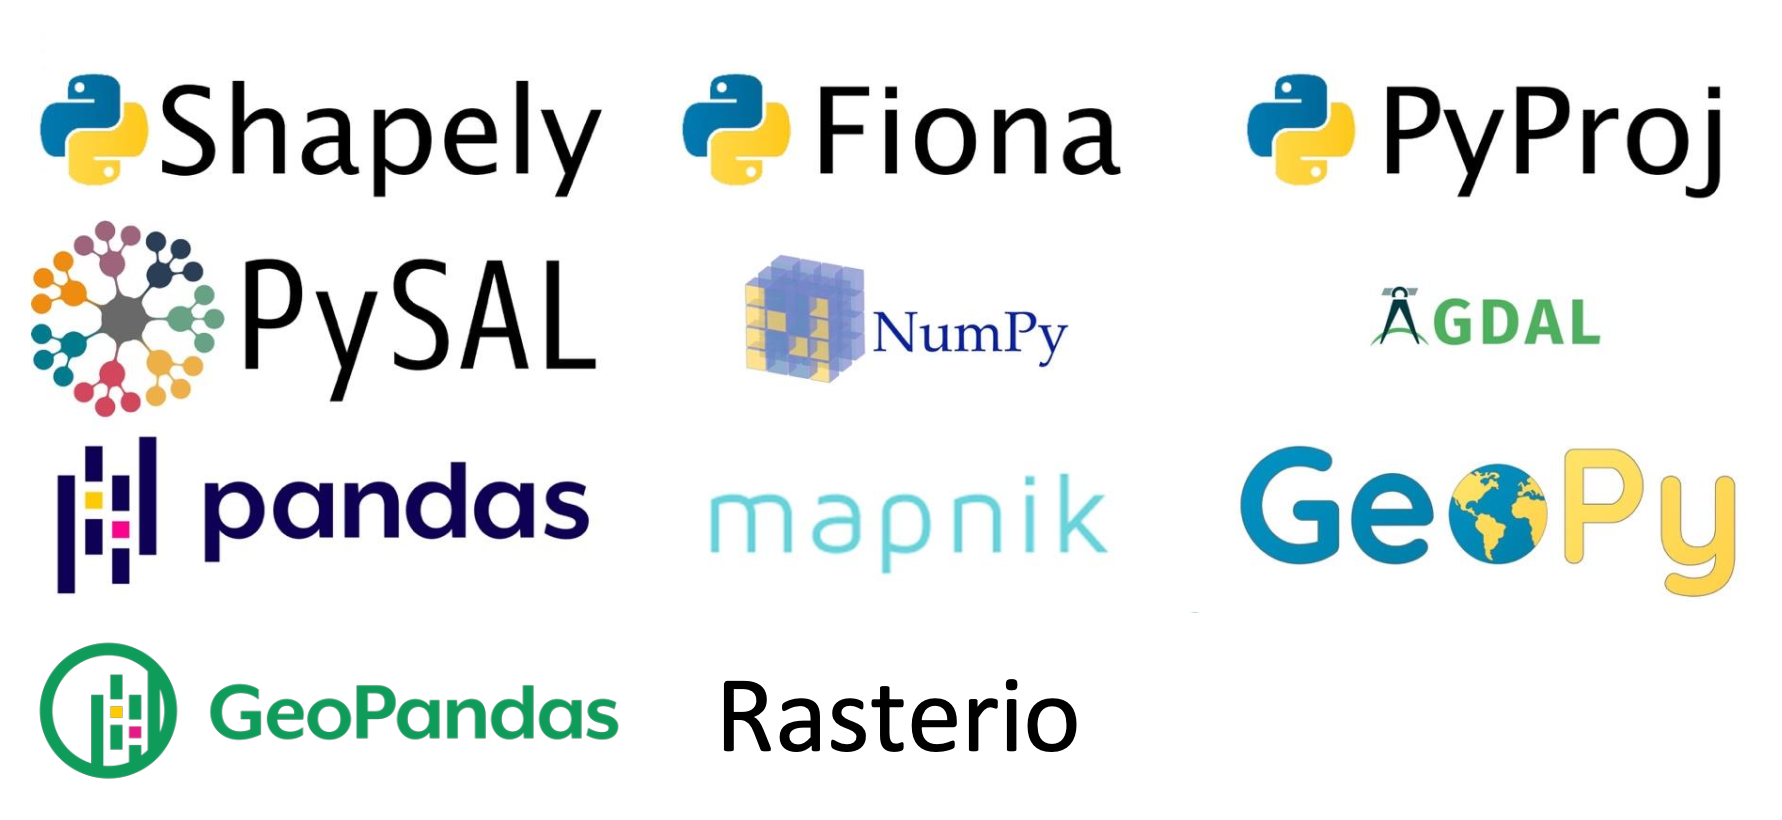

We have already covered some of these modules in the previous weeks, such as `geopandas`, `rasterio`, and `pyproj`. Different modules are at different levels of the spatial data processing pipeline. For example, `geopandas` is a high-level library that provides a user-friendly interface for working with geospatial data, while `rasterio` is used for reading and writing raster data. `pyproj` is a library for performing coordinate transformations and projections.

You can use `geopandas` to read shapefiles, but it is not the only option. Also sometimes, you may find the `geopandas` report some weird error messages when you try to read shapefiles. This is because `geopandas` is built on top of `Fiona` and `Shapely`, which are lower-level libraries that provide more control over the reading and writing of shapefiles. 

Here we will focus on `Fiona` and `Shapely`, which are powerful libraries for reading, writing, and manipulating shapefiles and geometric objects. More importantly, you will be able to understand the underlying mechanisms of how shapefiles are read and written, which will help you troubleshoot any issues you may encounter when working with `geopandas`.

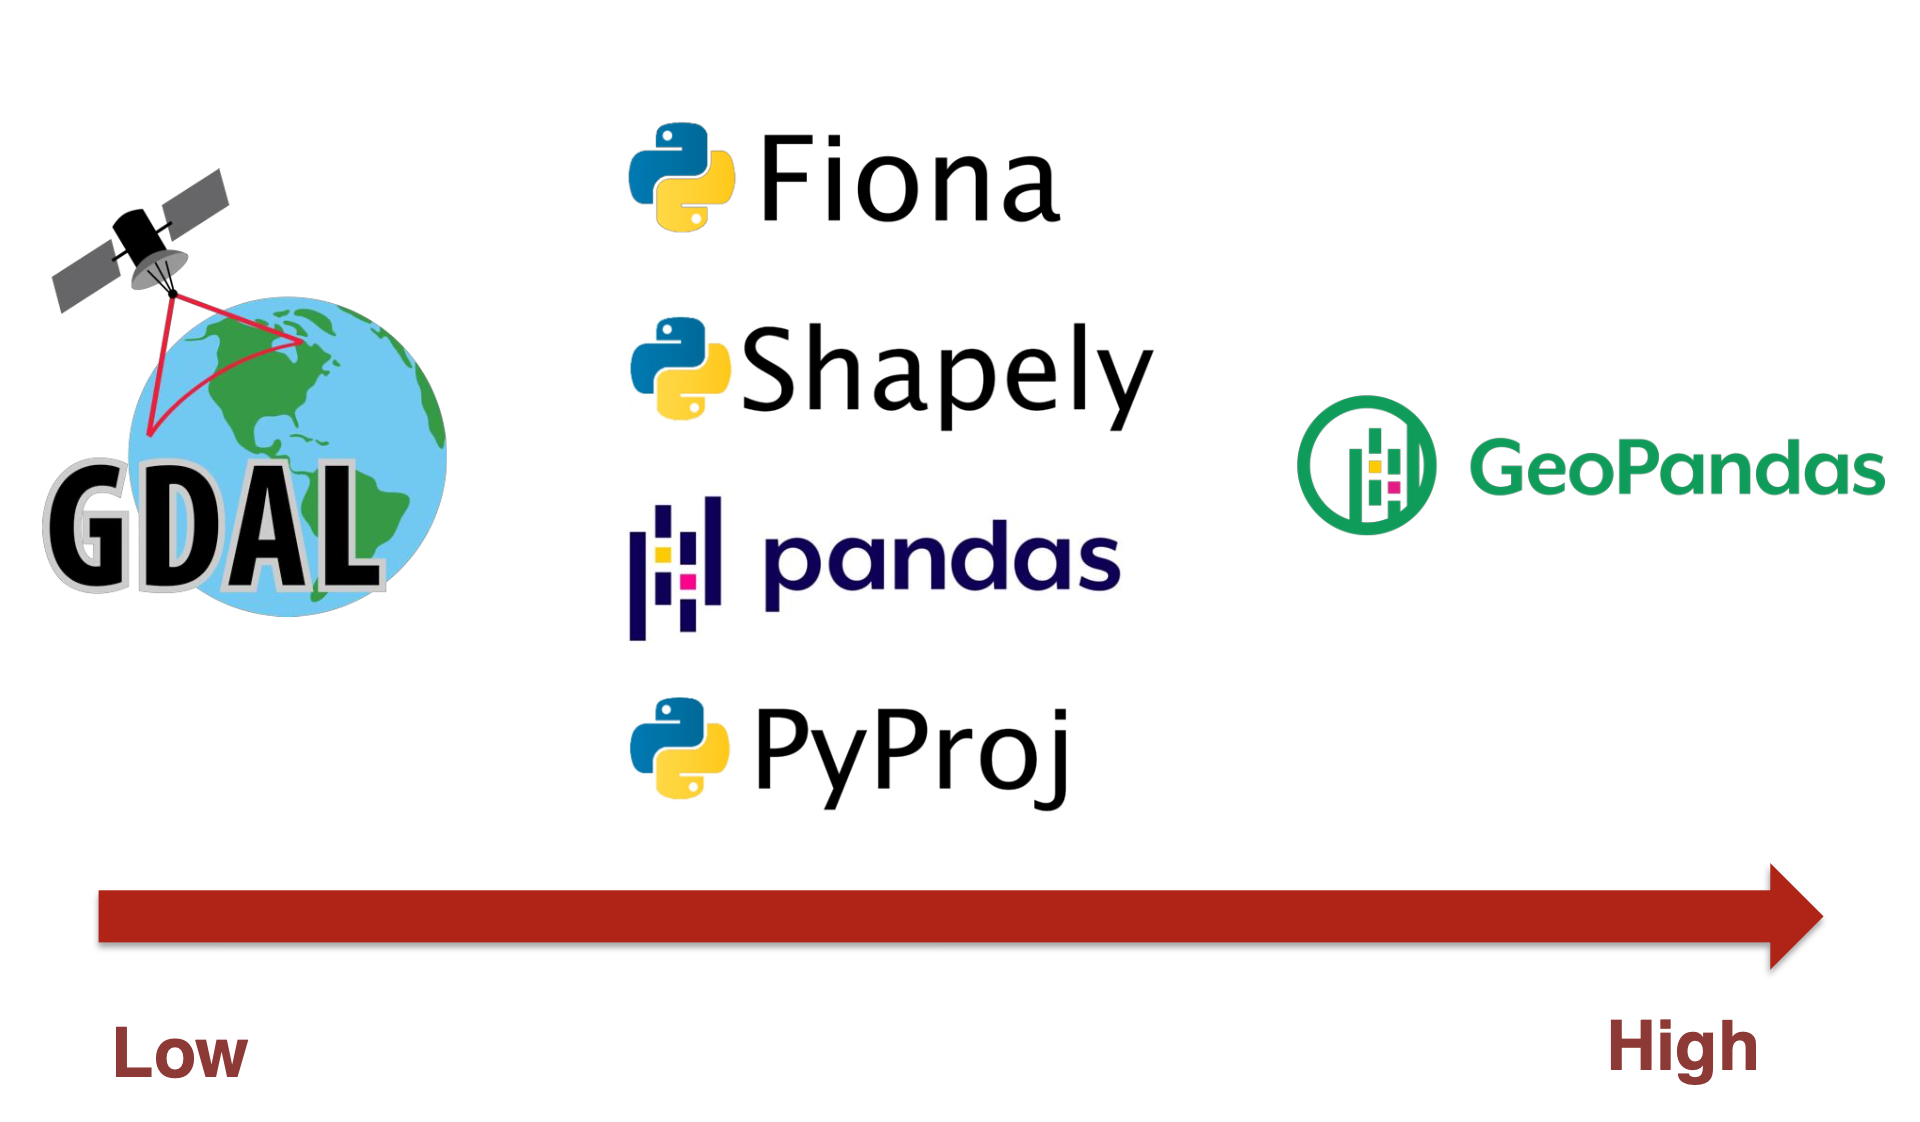

`Fiona` is used for reading and writing vector files (here we’re using Shapefiles), while `Shapely` is used for doing the manipulation and analysis of the geometric objects.



### This session will include some major sections, 

1. Read metadata, attributes, geometry of features in shapfile using fiona

1. Create shapefile based on the longitude and latitude 


1. Do buffer analysis using fiona+shapely

1. Do intersection of point feature class and polygon feature class

1. Do zonal statistics using fiona+shapely+rasterio

**References**:

- Fiona Manual, [http://toblerity.org/fiona/manual.html](http://toblerity.org/fiona/manual.html)
- Shapely Manual, [http://toblerity.org/shapely/manual.html](http://toblerity.org/shapely/manual.html)

- AZAVEA Research Blog, Using Shapely and Fiona to Locate High-Risk Traffic Areas, [https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/](https://www.azavea.com/blog/2016/10/05/philippines-road-safety-using-shapely-fiona-locate-high-risk-traffic-areas/)


### Read the geojson file using fiona

In [ ]:
# get the meta data of shapefile, such as spatial reference, field names, etc
import fiona
from fiona.crs import to_string
from shapely.geometry import mapping, shape

# you can read the shapefile as well
census_shp = 'data/zillow_neighborhoods.geojson'

with fiona.open(census_shp, 'r') as nb_lyr:
    driver = nb_lyr.driver # the driver of the shapefile
    schema = nb_lyr.schema  #schema of shapefile
    crs = nb_lyr.crs   # coordinate reference system of the shapefile
    meta = nb_lyr.meta # more details about the metadata of the shapefile

Let's take a look at what those metadata look like

In [3]:
print ('The driver is:', driver)
print ('The schema is:', schema)
print ('The coordinate reference system is:', crs)
print ('the metadata is:', meta)

The driver is: GeoJSON
The schema is: {'properties': {'ZillowName': 'str'}, 'geometry': 'Polygon'}
The coordinate reference system is: EPSG:4326
the metadata is: {'driver': 'GeoJSON', 'schema': {'properties': {'ZillowName': 'str'}, 'geometry': 'Polygon'}, 'crs': CRS.from_epsg(4326), 'crs_wkt': 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'}


We can check the geometry and attribute of all features (polygons in this case) in shapefile.

In [44]:
with fiona.open(census_shp, 'r') as nb_lyr:
    for feat in nb_lyr:
        # attribute of the neighborhood features
        attr = feat['properties']
        name = attr['ZillowName']  #you can find other attribute based on the metadata of the shapefile
        print ('The neighborhod is:', name)
        
        # get the geometry of the polygon feature
        geom = feat['geometry']
#         print ('geom is:', geom)

The neighborhod is: Academy Gardens
The neighborhod is: Airport
The neighborhod is: Allegheny West
The neighborhod is: Andorra
The neighborhod is: Aston Woodbridge
The neighborhod is: Bartram Village
The neighborhod is: Bella Vista
The neighborhod is: Belmont
The neighborhod is: Brewerytown
The neighborhod is: Bridesburg
The neighborhod is: Burnholme
The neighborhod is: Bustleton
The neighborhod is: Byberry
The neighborhod is: Callow Hill
The neighborhod is: Carroll Park
The neighborhod is: Cedar Park
The neighborhod is: Cedarbrook
The neighborhod is: Center City
The neighborhod is: Chestnut Hill
The neighborhod is: Chinatown
The neighborhod is: Clearview
The neighborhod is: Cobbs Creek
The neighborhod is: Crescentville
The neighborhod is: Crestmont Farms
The neighborhod is: Dearnley Park
The neighborhod is: Dickinson Narrows
The neighborhod is: Dunlap
The neighborhod is: East Falls
The neighborhod is: East Kensington
The neighborhod is: East Oak Lane
The neighborhod is: East Park
The 

If you don't like the `with` statement, you can also use the following code to read the shapefile:

In [45]:
nb_lyr = fiona.open(census_shp, 'r')
for feat in nb_lyr:
    # attribute of the neighborhood features
    attr = feat['properties']
    name = attr['ZillowName']  #you can find other attribute based on the metadata of the shapefile
    
    # get the geometry of the polygon feature
    geom = feat['geometry']
#         print ('geom is:', geom)

We can convert the dictionary `geom` variable into a shapely Polygon object using shapely. Here is one example of using shapely to deal with the geometry of features in shapefile. 

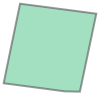

In [5]:
# the shape is a function in shapely, we import "from shapely.geometry import shape"
shape(geom)

### create a buffer of the shape

The projection is wgs84, and the unit is degree, so be careful for the buffer analysis. If you want to do buffer analysis, you need to convert the projection to a projected coordinate system, such as UTM, which uses meters as the unit. Here is a demostration of using a small number for buffer analysis. 

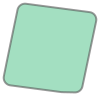

In [6]:
buff_geom = shape(geom).buffer(0.001) #1 degree is a long distance
buff_geom
# mapping(shape(point['geometry']).buffer(5.0))

**Note** Make sure your shapefile is in a projected coordinate system before you do buffer analysis. Like using the local projection with unit of feet or meters if you want to do buffer analysis. 

### Overlap analysis using fiona+shapely

We may want to find out which points fall within which polygons. This is a common spatial analysis task known as a point-in-polygon query. It can also apply to other geometry types, such as lines and polygons, points and lines, etc.

However, because of the huge amount of combination for seaching, it may take a long time to finish the analysis. We need to think about how to optimize the code to speed up the analysis. 

For example, you want to find a book with name of "Python for Geospatial Data Science" in a library with 1 million books. If you search the book one by one, it will take a long time to finish the search. But if you search the index of the book first, it will be much faster. Similarly, for spatial analysis, we can use spatial indexing to speed up the search process.

### RTree

RTree is a spatial indexing library that can be used to speed up spatial queries. It works by creating a hierarchical structure of bounding boxes that can be used to quickly eliminate large portions of the search space.

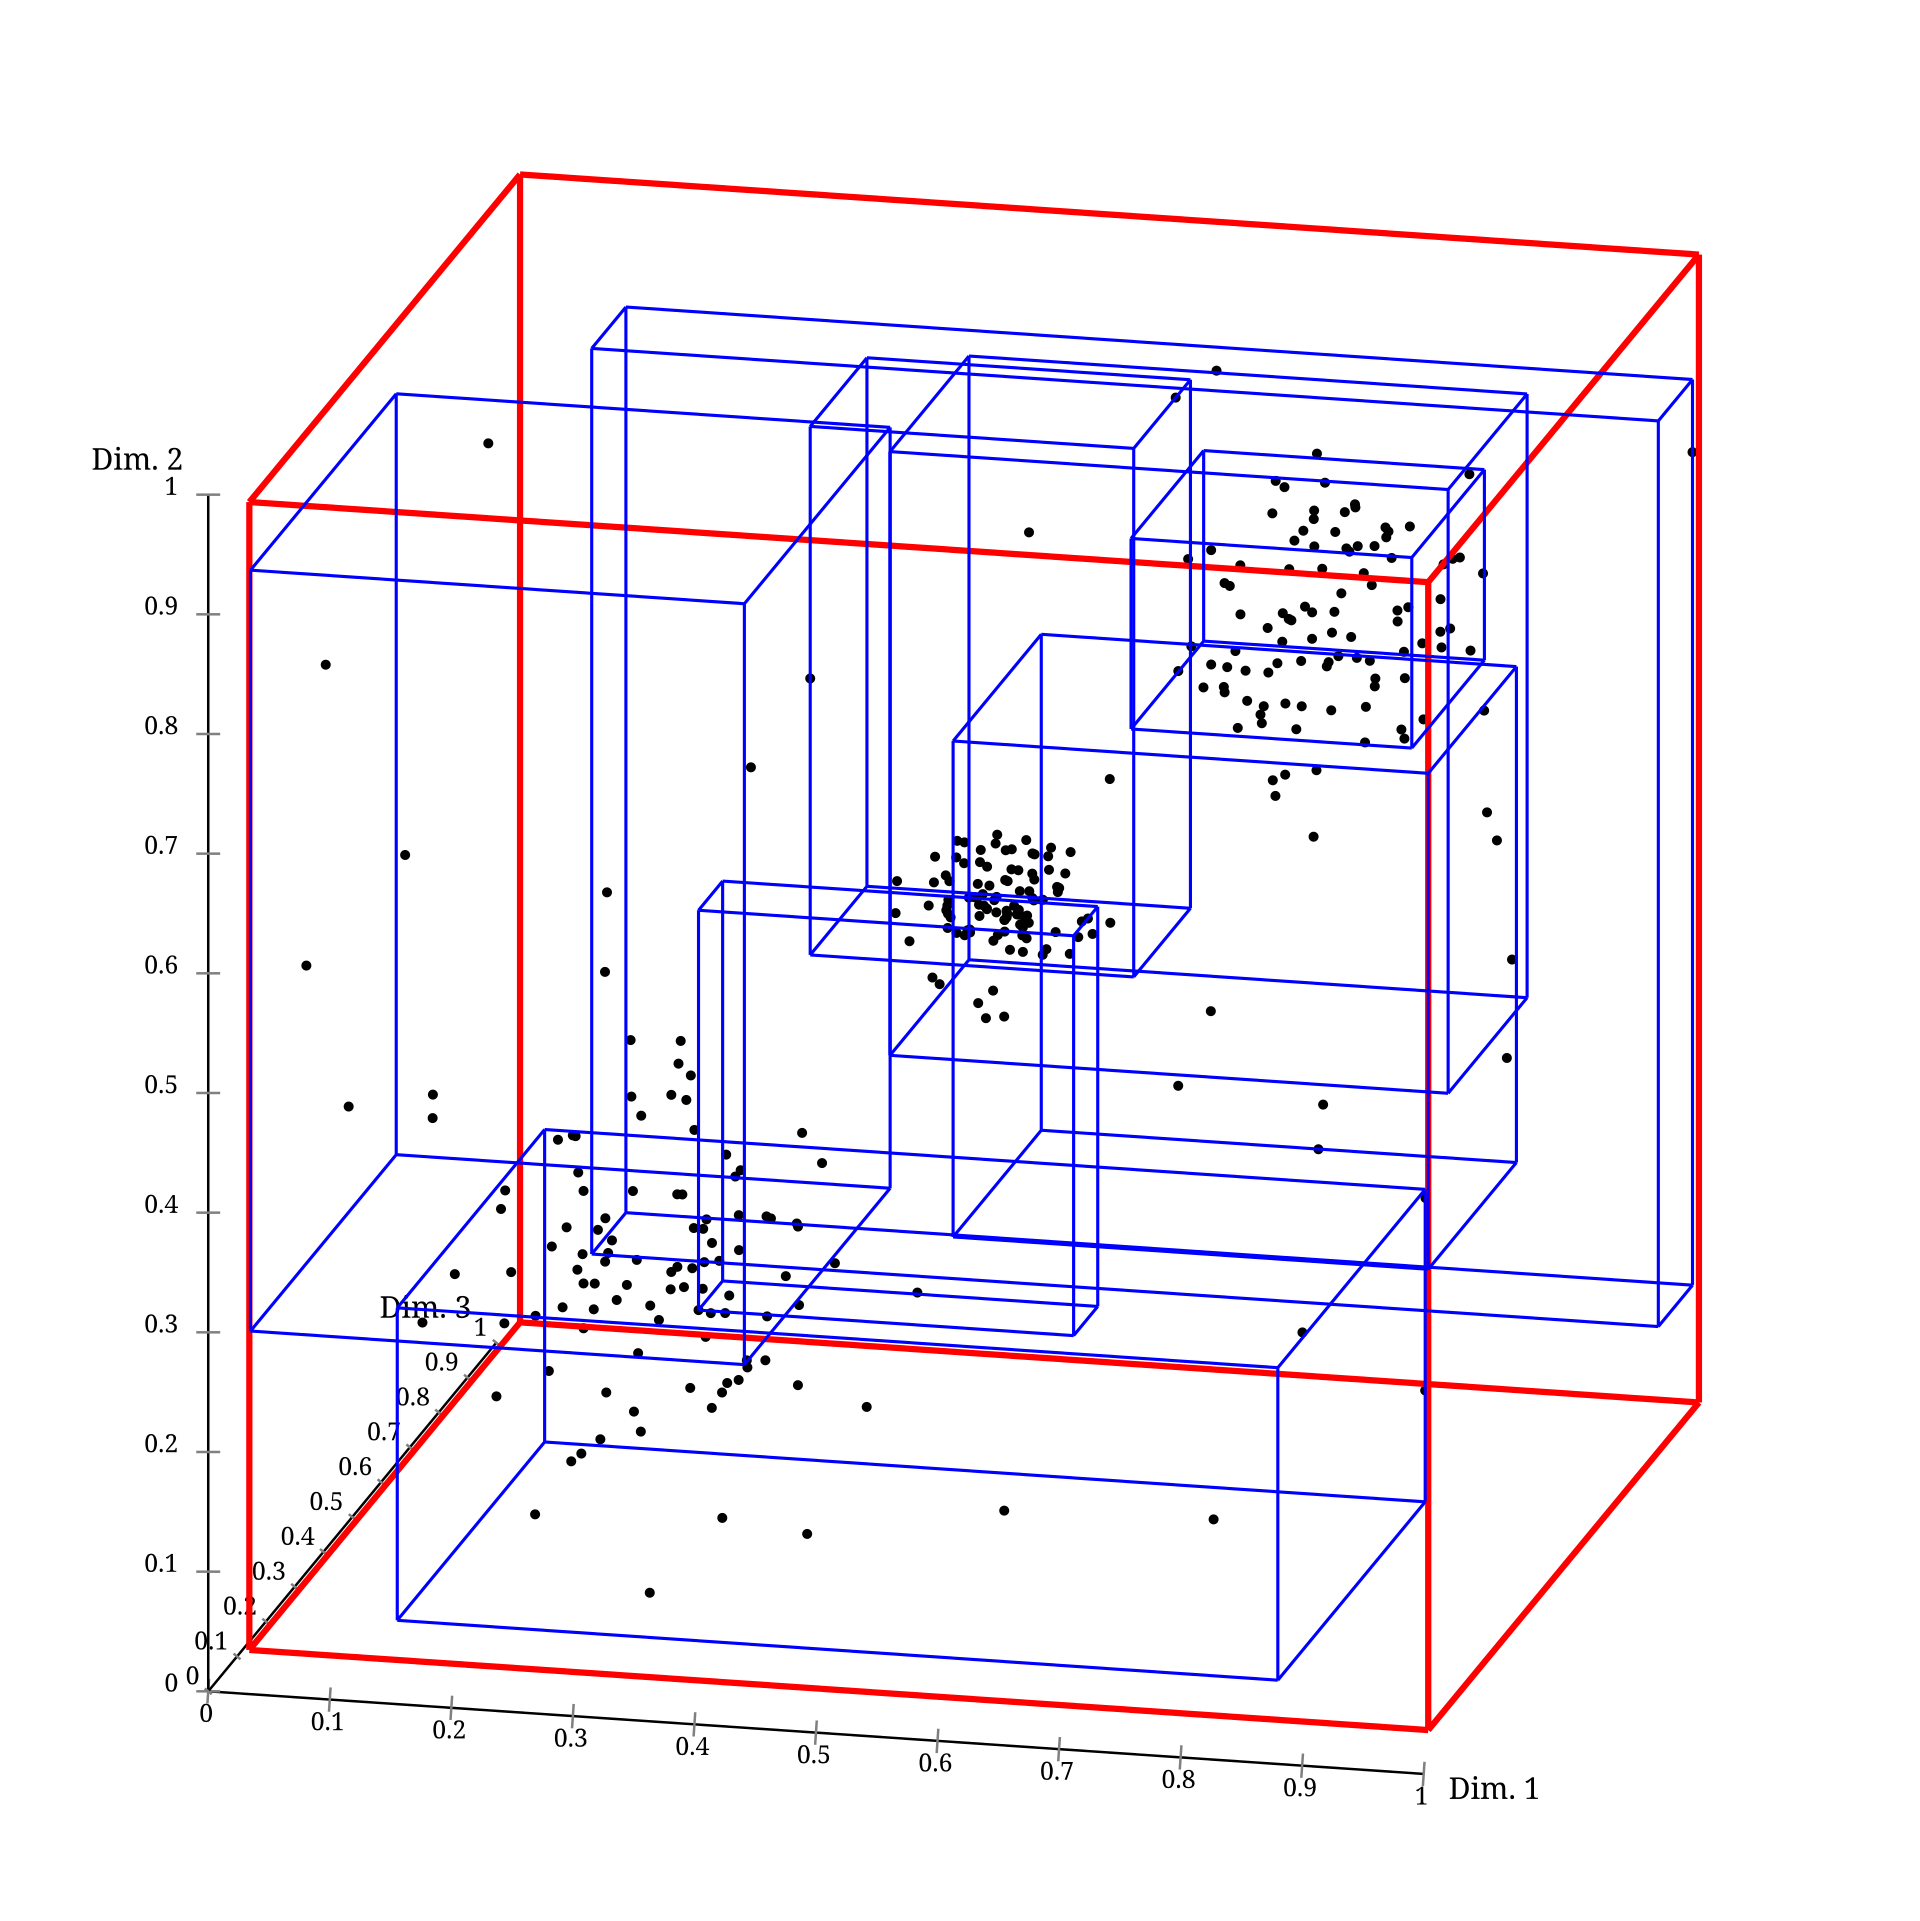{width=200}

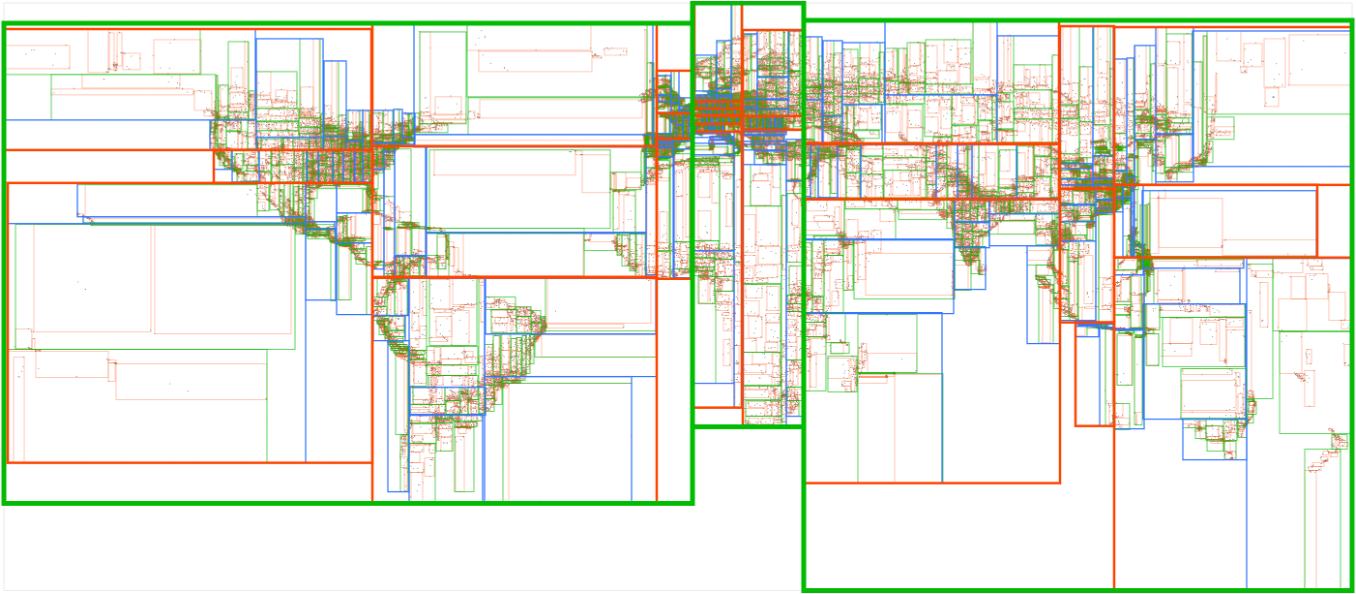{width=400}



Here is a simple example of find the amount of tree points within each census tract polygon.

In [9]:
# !pip install rtree

#### Create spatial index for point features

The two shapefiles are in projection of WGS84, which uses degree as the unit. You can overlay them in Desktop GIS software. But, when do the spatial analysis, you need to convert them into a projected coordinate system, such as UTM, which uses meters as the unit. Here you can reproject both of then to a local projection (epsgcode: 2272) with unit of feet or meters if you want to do buffer analysis.

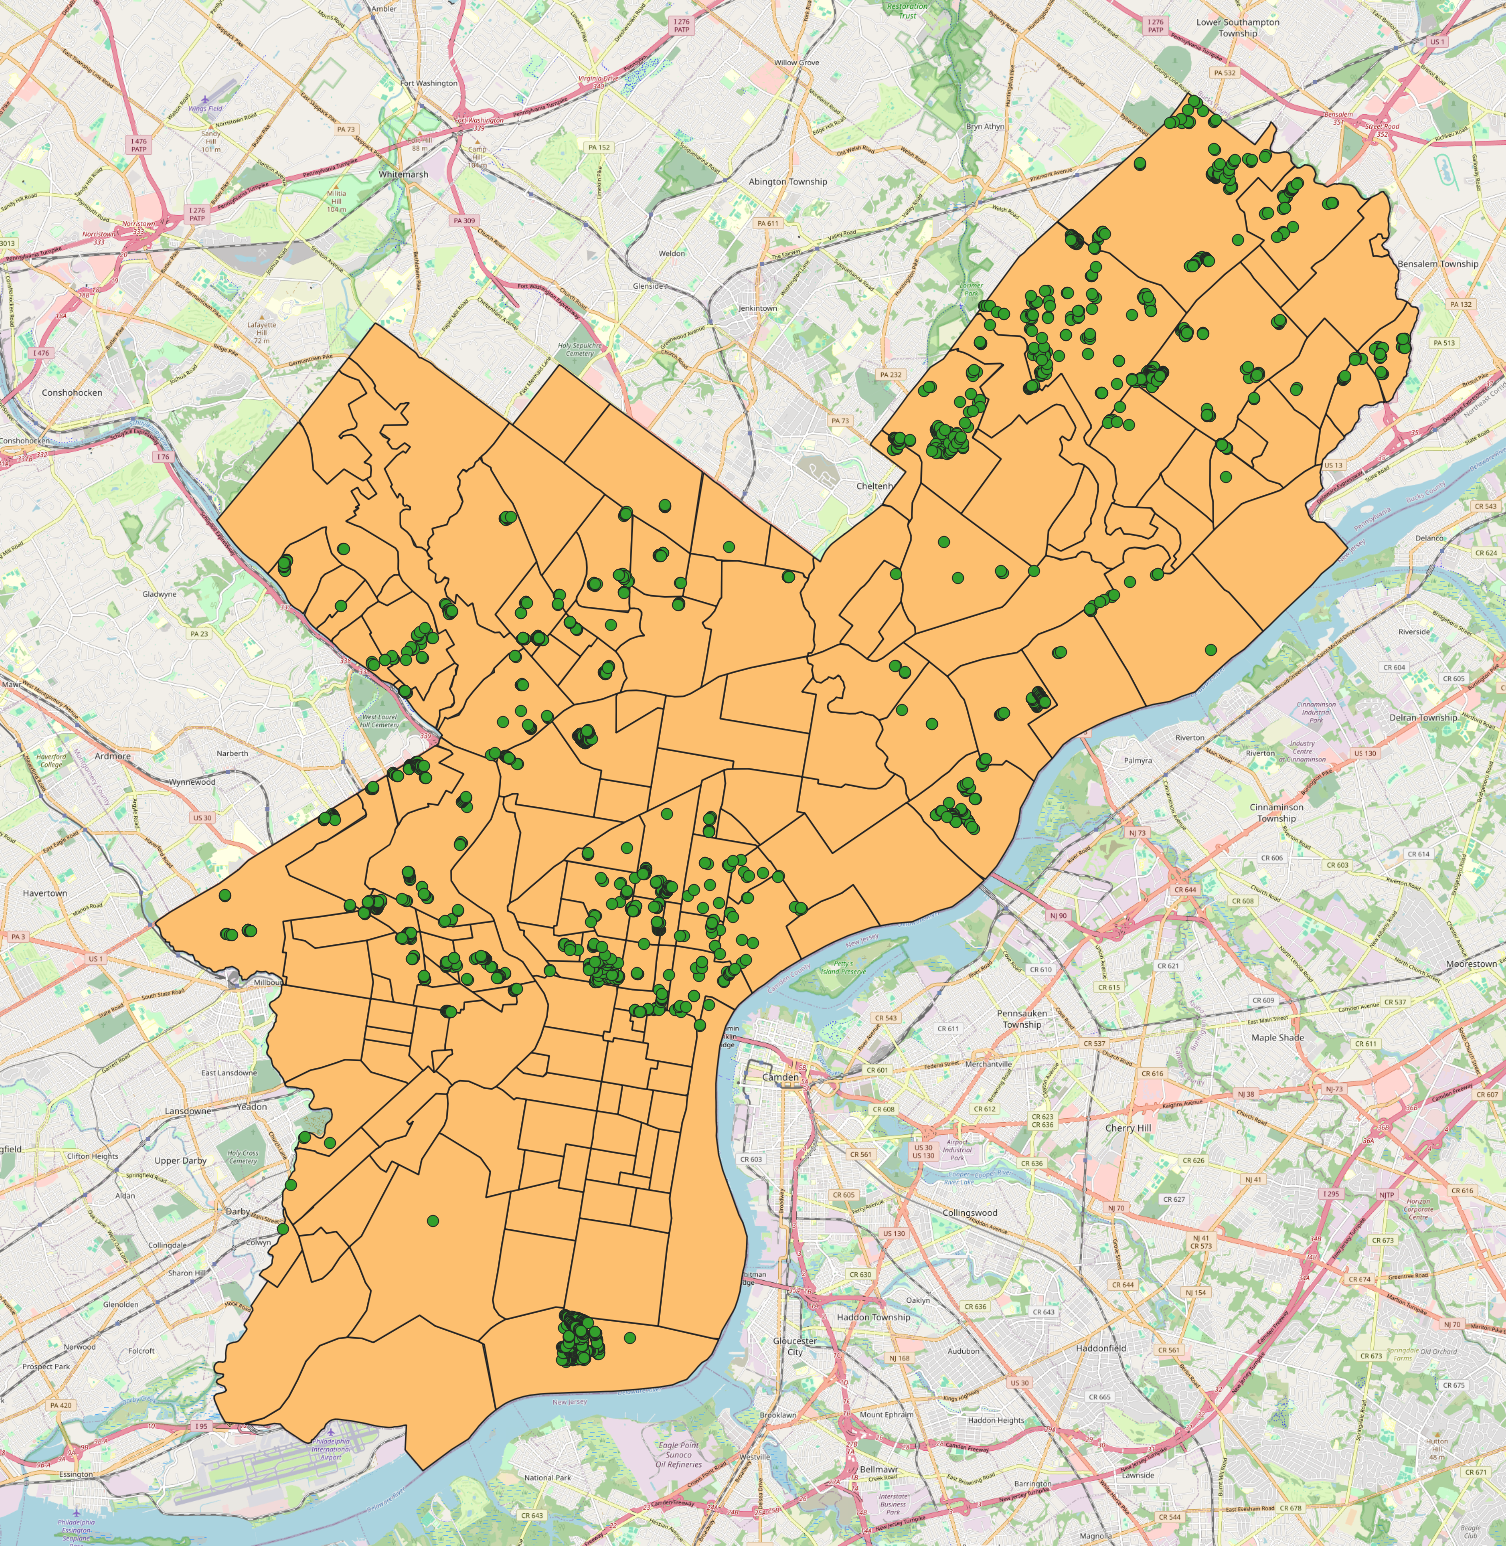

The [neighborhood polygon](data/zillow_nb.geojson) and the [tree points](data/tree_site.geojson) are in the same projection, so we can do the spatial analysis directly.

#### prepare the polygon features and build empty RTree index

In [6]:
import rtree

# neighborhood_map = 'data/zillow_neighborhoods.geojson'
# treesite_map = 'data/ppr_tree_canopy_points_2015.geojson'

neighborhood_map = 'data/zillow_nb.geojson'
treesite_map = 'data/tree_site.geojson'
outPolygonShp = 'data/trees_neighborhood.shp'

pnt_lyr = fiona.open(treesite_map, 'r')     
# create an empty spatial index object
index = rtree.index.Index()


#### Populate the spatial index with point features

In [4]:
# populate the spatial index, the polygon features
i = 0
for fid, feature in pnt_lyr.items():
    i = i + 1
    if i % 1000 == 0: print (i)
    geometry = shape(feature['geometry'])
    
    # add a buffer in order to create a r-tree
    geometry_buffered = geometry.buffer(0.0001) # buffer 0.0001 degree, about 11 meters
    geotype = feature['geometry']['type']
    
    index.insert(fid, geometry_buffered.bounds)
    
10000

1000
2000


10000

#### Start the overlay based on the built rtree

There are two steps to do the overlay analysis, step 1. using the rtree index to find the candidate points that may fall within the polygon; step 2. using shapely to check if the candidate points really fall within the polygon.


In [8]:
# loop all polygons and assign GVI values
with fiona.open(neighborhood_map, 'r') as polygon_lyr:
    schema = polygon_lyr.schema.copy()
    schema['properties']['tree_num']='int' 
    input_crs = polygon_lyr.crs
    
    # write the intersected point into the new shapefile
    with fiona.open(outPolygonShp, 'w', 'ESRI Shapefile', schema, input_crs) as output:
        
        # loop the polygon feature
        for idx, featPoly in enumerate(polygon_lyr):
            if idx % 100 == 0:
                print('Polygon:', idx)
            
            geomPoly = shape(featPoly['geometry'])                
            attriPoly = featPoly['properties']
            
            # using the bounding box to find the close but may not intersected point feature
            fids = [int(i) for i in index.intersection(geomPoly.bounds)]
            # print("i have narrowed down to ", len(fids))
            
            # count the number of accidents
            count = 0
            
            # loop all features in bounding box and then judge if they are intersected
            for fid in fids:
                featPnt = pnt_lyr[fid]
                geomPnt = shape(featPnt['geometry'])
                
                # if the point is intersected with the polygon, then save the point feature into the output shapefile
                if geomPoly.contains(geomPnt): #intersect
                    count = count + 1
            
            attriPoly['tree_num']=count
            output.write({'geometry': mapping(geomPoly),'properties': attriPoly})

Polygon: 0
Polygon: 100


/var/folders/7g/px0llbj54z37p076r6853ggh0000gn/T/ipykernel_83312/4118696468.py:34: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  attriPoly['tree_num']=count


## Zonal statistics using geopandas+rasterio
We have discussed about using the `zonalstats` to do the zonal statistics in Week-5B. Here we will demonstrate how to do the zonal statistics using `geopandas` and `rasterio`. You will have more control of the process using this method.

#### Prepare the input data
You will need to prepare the raster data and the shapefile. Also, make sure they are in the same projection. It is easier to reproject the shapefile match with the raster data, because the raster data is usually large and it is time consuming to reproject the raster data.

In [46]:

import geopandas as gpd

# Read the GeoJSON
neighborhood_map = 'data/zillow_nb.geojson'
gdf = gpd.read_file(neighborhood_map)

# Check the current CRS
print(gdf.crs)

# Reproject to EPSG:32618 to match with the raster data
gdf_utm = gdf.to_crs(epsg=32618)

EPSG:2272


#### Conduct the zonal statistics
Here we will loop through each polygon in the shapefile, and for each polygon, we will mask the raster data using the polygon, and then calculate the statistics of the masked raster data. Different from the `zonalstats` module, you will be able to control the statistics you want to calculate, such as mean, median, min, max, std, etc.

In [72]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

import numpy as np


def calculate_NDVI(nir, red):
    """
    Calculate the NDVI from the NIR and red landsat bands
    """

    # Convert to floats
    nir = nir.astype(float)
    red = red.astype(float)

    # Get valid entries
    check = np.logical_and(red.mask == False, nir.mask == False)

    # Where the check is True, return the NDVI, else return NaN
    ndvi = np.where(check, (nir - red) / (nir + red), np.nan)
    
    # Return
    return ndvi


# 2. Open raster
results = []
with rasterio.open("data/landsat8_philly.tif") as src:
    for geom in gdf_utm.geometry:
        # Mask Red (band 4) and NIR (band 5)

        masked, mask_transform = mask(
            dataset=src,              # The original raster data
            shapes=[geom],  # The vector geometry we want to crop by
            crop=True,                    # Optional: remove pixels not within boundary
            all_touched=True,             # Optional: get all pixels that touch the boudnary
            filled=False,                 # Optional: do not fill cropped pixels with a default value
        )

        # Note that the indexing here is zero-based, e.g., band 1 is index 0
        red = masked[3]
        nir = masked[4]
        ndvi = calculate_NDVI(nir, red)

        # red, _ = rasterio.mask.mask(src, [geom], crop=True, indexes=4)
        # nir, _ = rasterio.mask.mask(src, [geom], crop=True, indexes=5)
        
        # red = red.astype(float)
        # nir = nir.astype(float)

        # # Mask out nodata
        # if src.nodata is not None:
        #     red[red == src.nodata] = np.nan
        #     nir[nir == src.nodata] = np.nan

        # # NDVI formula (add small epsilon to avoid /0)
        # ndvi = (nir - red) / (nir + red + 1e-6)

        # Flatten and drop NaNs
        ndvi = ndvi[np.isfinite(ndvi)]

        # Compute stats
        if ndvi.size > 0:
            mean_val = float(ndvi.mean())
            min_val = float(ndvi.min())
            max_val = float(ndvi.max())
        else:
            mean_val = min_val = max_val = None

        results.append({
            "ndvi_mean": mean_val,
            "ndvi_min": min_val,
            "ndvi_max": max_val
        })

# 3. Attach results safely
res_gdf = gpd.GeoDataFrame(results, index=gdf_utm.index)


# Drop old cols if they already exist (prevents overlap error)
for col in res_gdf.columns:
    if col in gdf_utm.columns:
        gdf_utm = gdf_utm.drop(columns=col)

# Merge results
gdf_utm = gdf_utm.join(res_gdf)

print(gdf_utm.head())

         ZillowName                                           geometry  \
0   Academy Gardens  POLYGON ((500127.271 4434899.076, 500464.133 4...   
1           Airport  POLYGON ((483133.506 4415847.15, 483228.716 44...   
2    Allegheny West  POLYGON ((485837.663 4428133.6, 485834.655 442...   
3           Andorra  POLYGON ((480844.652 4435202.29, 480737.832 44...   
4  Aston Woodbridge  POLYGON ((499266.779 4433715.944, 499265.975 4...   

   ndvi_mean  ndvi_min  ndvi_max  
0   0.311035  0.018471  0.582076  
1   0.176434 -0.170573  0.654791  
2   0.221690 -0.055709  0.623701  
3   0.431367  0.038368  0.596069  
4   0.312406  0.029139  0.568488  


#### Let's check our result quickly

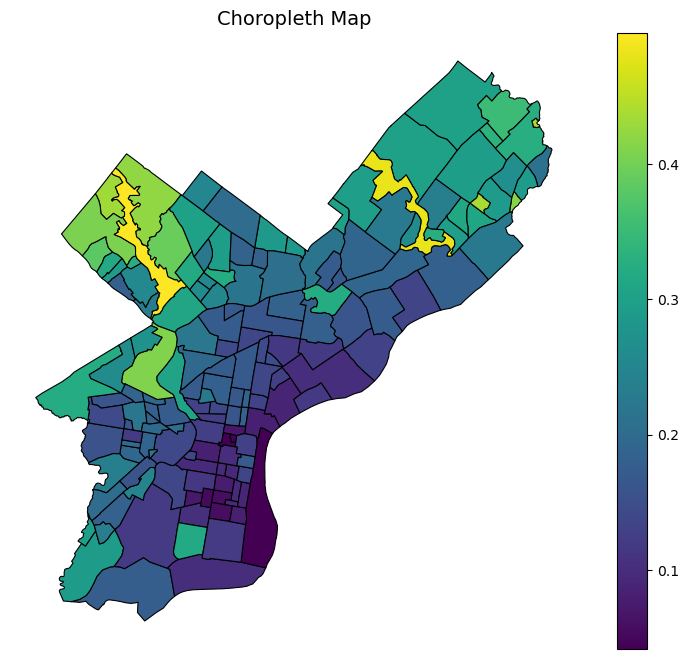

In [74]:
from matplotlib import pyplot as plt

# Get max value for scaling
max_val = gdf_utm["ndvi_mean"].max()
min_val = gdf_utm["ndvi_mean"].min()

# Plot choropleth
ax = gdf_utm.plot(
    column="ndvi_mean",       # column to color by
    cmap="viridis",       # colormap
    linewidth=0.8,
    edgecolor="black",
    legend=True,
    vmin=min_val,               # minimum for color scale
    vmax=max_val,         # maximum for color scale
    figsize=(10, 8)
)

plt.title("Choropleth Map", fontsize=14)
plt.axis("off")
plt.show()